## This version uses the correct matrices in the linear equation. It however seems to give nearly indentical results to my previous version.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [2]:
x = np.arange(-15, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

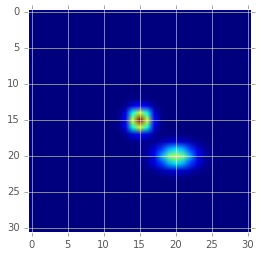

In [3]:
import scipy.stats

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

def gaussian2d(grid, m=None, s=None):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    var = scipy.stats.multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

#x, y = np.mgrid[-15:16:1, -15:16:1]
#grid = np.dstack((x, y))
g1 = gaussian2d(grid) + gaussian2d(grid, [5,5], [3,1])
plt.imshow(g1)

## Update: it looks like the actual code uses chebyshev1 polynomials!

Note these are essentially the same but with different scale factors.

In [4]:
# This code works, but I think the next cell is faster.
from numpy.polynomial.chebyshev import chebgrid2d

h0 = chebgrid2d(x, y, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebgrid2d(x, y, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 0, 1]])

In [5]:
from numpy.polynomial.chebyshev import chebval2d
h0 = chebval2d(x0, y0, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebval2d(x0, y0, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 0, 1]])

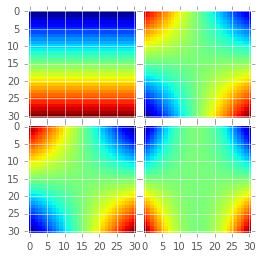

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
igrid[0].imshow(h0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(h1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(h2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(h3, interpolation='none')  # The AxesGrid object work as a list of axes.

In [7]:
## The following code does exactly the same as the above:
from numpy.polynomial.chebyshev import chebval
def chebval2d_try(x, y, xord, yord):
    cx = chebval(x, xord)
    cy = chebval(y, yord)
    h0 = np.outer(cx, cy)
    return h0

if False:
    #h0 = chebval2d_try(x, y, [1, 0, 0], [0, 1, 0])
    h0 = chebval2d_try(x, y, [0, 1, 0], [0, 1, 0])
    #h0 = chebval2d_try(x, y, [0, 1, 0], [0, 0, 1])
    print h0.shape
    plt.imshow(h0)

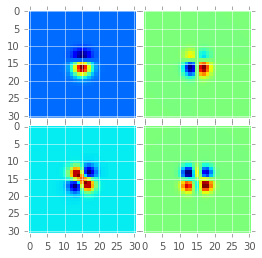

In [8]:
gh0 = gaussian2d(grid, s=[3., 3.]) * h0
gh1 = gaussian2d(grid, s=[3., 3.]) * h1
gh2 = gaussian2d(grid, s=[3., 3.]) * h2
gh3 = gaussian2d(grid, s=[3., 3.]) * h3
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
extent = (x0.min(), x0.max(), y0.min(), y0.max())
igrid[0].imshow(gh0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(gh1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(gh2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(gh3, interpolation='none')  # The AxesGrid object work as a list of axes.

## Generate AL basis funcs now...

use same parameters as from the stack.

TBD: is a degGauss of 2 mean it goes up to order 2 (i.e. $x^2$)? Or is it 2 orders so it only goes up to linear ($x$)? Probably the former, so that's what we'll use.

In [9]:
# Parameters from stack
sigGauss = [0.75, 1.5, 3.0]
degGauss = [4, 2, 2]
betaGauss = 1   # in the Becker et al. paper sigGauss is 1 but PSF is more like 2 pixels?
# Parameters from and Becker et al. (2012)
#sigGauss = [0.75, 1.5, 3.0]
#degGauss = [6, 4, 2]

def chebGauss2d(x, y, grid, m=None, s=None, ord=[0,0], beta=1., verbose=False):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    coefLen = np.max(ord)+1
    coef0 = np.zeros(coefLen)
    coef0[ord[0]] = 1
    coef1 = np.zeros(coefLen)
    coef1[ord[1]] = 1
    if verbose:
        print s, ord, coef0, coef1
    ga = gaussian2d(grid, m, np.array(s)/beta)
    ch = chebval2d(x, y, c=np.outer(coef0, coef1))
    return ch * ga

In [10]:
basis = [chebGauss2d(x0, y0, grid, m=[0,0], s=[sig0,sig1], ord=[deg0,deg1], beta=betaGauss, verbose=True) for i0,sig0 in enumerate(sigGauss) for i1,sig1 in enumerate(sigGauss) for deg0 in range(degGauss[i0]+1) for deg1 in range(degGauss[i1]+1)]
print len(basis), basis[0].shape, x0.shape, grid.shape, basis[0].reshape(x0.shape).shape

[0.75, 0.75] [0, 0] [ 1.] [ 1.]
[0.75, 0.75] [0, 1] [ 1.  0.] [ 0.  1.]
[0.75, 0.75] [0, 2] [ 1.  0.  0.] [ 0.  0.  1.]
[0.75, 0.75] [0, 3] [ 1.  0.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [0, 4] [ 1.  0.  0.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [1, 0] [ 0.  1.] [ 1.  0.]
[0.75, 0.75] [1, 1] [ 0.  1.] [ 0.  1.]
[0.75, 0.75] [1, 2] [ 0.  1.  0.] [ 0.  0.  1.]
[0.75, 0.75] [1, 3] [ 0.  1.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [1, 4] [ 0.  1.  0.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [2, 0] [ 0.  0.  1.] [ 1.  0.  0.]
[0.75, 0.75] [2, 1] [ 0.  0.  1.] [ 0.  1.  0.]
[0.75, 0.75] [2, 2] [ 0.  0.  1.] [ 0.  0.  1.]
[0.75, 0.75] [2, 3] [ 0.  0.  1.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [2, 4] [ 0.  0.  1.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [3, 0] [ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[0.75, 0.75] [3, 1] [ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[0.75, 0.75] [3, 2] [ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[0.75, 0.75] [3, 3] [ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[0.75, 0.75] [3, 4] [ 0.

In [11]:
print len(basis), basis[0].shape, basis[0].reshape(x0.shape).shape, 31*31
basis2 = np.dstack(basis).T  # put the bases into an array
print basis2.shape, basis2[0].shape, basis2[0].reshape(x0.shape).shape
print basis[0].min(), basis[0].max(), basis2.min(), basis2.max()

121 (31, 31) (31, 31) 961
(121, 31, 31) (31, 31) (31, 31)
1.0924820179e-131 0.212206590789 -14.1624248714 14.1624248714


Make the two "images". `im1` is the template, `im2` is the science image.

NOTE: having sources near the edges really messes up the fitting (probably because of the convolution). So make sure no sources are near the edge.

NOTE: also it seems that having the variable source with a large flux increase also messes up the fitting (seems to lead to overfitting -- perhaps to the source itself). This might be fixed by adding more constant sources.

280 -0.187845065956 -11.0950094076
DescribeResult(nobs=261121, minmax=(-1442.5062761680874, 489.35343836275547), mean=0.028623795766207702, variance=3455.6570550156248, skewness=-8.428661325421526, kurtosis=118.40181303738765)


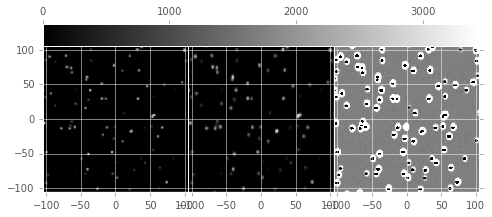

In [12]:
np.random.seed(66)

xim = np.arange(-255, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))
n_sources = 500
fluxes = np.random.uniform(50, 30000, n_sources)
xposns = np.random.uniform(xim.min()+5, xim.max()-5, n_sources)
yposns = np.random.uniform(yim.min()+5, yim.max()-5, n_sources)

# Make the source closest to the center of the image the one that increases in flux
ind = np.argmin(xposns**2. + yposns**2.)
print ind, xposns[ind], yposns[ind]

sig1 = 0.2  # sigma of template
sig2 = 0.2  # sigma of science image
im1 = np.random.normal(scale=sig1, size=x0im.shape)
im2 = np.random.normal(scale=sig2, size=x0im.shape)

psf1 = 1.6 # sigma in pixels im1 will be template
psf2 = 2.2 # sigma in pixels im2 will be science image. make the psf in this image slighly offset and elongated
for i in range(n_sources):
    im1 += fluxes[i] * gaussian2d(imgrid, m=[xposns[i],yposns[i]], s=[psf1, psf1])
    im2 += fluxes[i] * gaussian2d(imgrid, m=[xposns[i]+0.2,yposns[i]+0.2], s=[psf2, psf2*1.5])
    if i == ind:
        im2 += (fluxes[i]/1.) * gaussian2d(imgrid, m=[xposns[i]+0.2,yposns[i]+0.2], s=[psf2, psf2*1.5])

fig = plt.figure(1, (9, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow((im2-im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10))
igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - im1, axis=None)

Convolve im1 (template) with the basis functions, and make these the *new* bases.

In [13]:
import scipy.signal

basis2 = [scipy.signal.fftconvolve(im1, b, mode='same') for b in basis]
print len(basis2), basis2[0].shape

basis2a = np.vstack([b.flatten() for b in basis2]).T
print basis2a.shape, im2.flatten().shape

121 (511, 511)
(261121, 121) (261121,)


Do the linear fit to compute the matching kernel. The resulting fit is the convolved diffim.

[  1.21658945e+04   3.69512654e+02   5.82847162e+02   4.39193167e-02
   2.76803976e+01   8.67450409e+03   2.74396086e-01   8.65824567e+02
   5.36705753e-02   1.97058358e+01   5.39932762e+03   3.71862746e+01
   4.76919426e+02   3.26794326e-02   1.22612324e+01  -1.33137899e-02
  -3.23006589e-02   5.61586800e-02  -4.57388407e-04  -3.66158930e-04
  -1.45529980e+00   8.29585361e-01  -1.55540416e+00  -4.69260027e-04
  -7.84740695e-03   8.87016099e+01  -4.96766336e+02   8.76361171e+02
  -2.05995803e+00   4.41308929e-01  -9.26590018e-01  -1.50951259e+01
   2.59064787e+01  -4.56192429e+01  -5.27091043e-03  -1.58718495e-02
   2.51587500e-02   6.33933975e-01  -3.63011700e-01   7.34553896e-01
  -7.47347308e+01   7.29599935e+01  -1.55667258e+02   4.19477037e-01
   9.75610117e-02  -1.05732296e-01   2.97315112e-01  -1.38691704e+00
   2.82165000e+00  -2.71822197e-04  -6.74370590e-04   1.02495782e-03
  -5.34441689e-03   3.35847303e-03  -6.99613058e-03  -1.70580225e+04
  -2.90965129e+00   8.95824960e+02

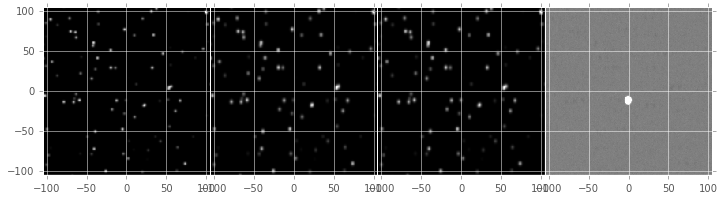

In [14]:
pars, resid, _, _ = np.linalg.lstsq(basis2a, im2.flatten())
print pars
fit = (pars * basis2a).sum(1).reshape(im2.shape)
print resid, np.sum((im2 - fit.reshape(im2.shape))**2), np.sum((im2 - im1)**2)
print basis2a.shape, fit.shape

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow((im2 - fit)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10))
#igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - fit, axis=None)

Look at the resulting matching kernel by multiplying the fitted parameters times the original basis funcs. and test that actually convolving it with the template gives us a good subtraction.

(121,) (961, 121)
1.00045128413


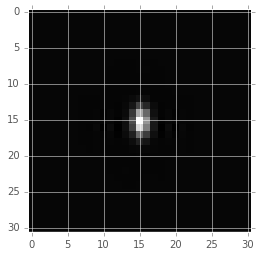

In [15]:
kbasis = np.vstack([b.flatten() for b in basis]).T
print pars.shape, kbasis.shape
kfit = (pars * kbasis).sum(1).reshape(basis[0].shape)
print kfit.sum()
kfit /= kfit.sum()  # this is necessary if the variable source changes a lot - prevent the kernel from incorporating that change in flux
plt.imshow(kfit, interpolation='none', cmap='gray')  # this plots the matching kernel

Compare the convolved template to the science image. Also plot the new diffim for comparison.

DescribeResult(nobs=261121, minmax=(-1.0502014153050858, 450.34468520246878), mean=0.028705387858830325, variance=6.6424662056329131, skewness=115.89876180474081, kurtosis=15214.599435467739)


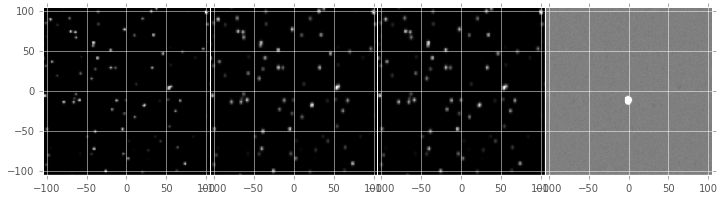

In [16]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit, mode='constant')
fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # original template (red)
igrid[1].imshow(conv_im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # convolved template (blue)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # science image (dotted, purple)
igrid[3].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10)) # diffim (grey)
print scipy.stats.describe(im2 - conv_im1, axis=None)

Create the $b_i$ and $M_{ij}$ from the A&L (1998) and Becker (2012) papers. This was done wrong in the previous version of notebook 3 (and above), although it gives identical results.

(121,)
(121, 121)
[ -1.48281462e+01   3.18936372e-01  -7.86281242e-01   4.45167090e-02
  -3.28447051e-02  -1.57051862e-01   6.00652611e-01   8.91472310e-01
   1.03880223e-01   1.07687493e-02  -7.42462337e-01   4.43415824e-01
  -4.62908637e-03   2.89862876e-02  -9.65051514e-04  -1.57177007e-02
  -5.72975472e-02   6.08776546e-02  -5.60228533e-04  -3.40356290e-04
  -4.17253606e-02   4.97498029e-03  -9.08136902e-03  -5.11221863e-04
  -4.27554341e-04   2.86542942e+00   5.10589229e-01  -5.40382939e-01
   1.22789954e-01   7.47199868e-01  -7.57220621e-01  -9.99205364e-01
  -1.46058605e-01   2.52198723e-02  -6.37700491e-03  -2.71491861e-02
   2.74875694e-02  -6.39999655e-03   2.87388568e-03  -2.32118107e-03
   3.42659772e+00   4.01022795e-01  -5.36359782e-02  -1.98338989e-01
   1.57418121e-01  -1.85115555e-01  -6.77068333e-02  -1.76725118e-02
   8.41492783e-03  -3.14915615e-04  -1.05688799e-03   1.11235781e-03
   5.22740385e-04   5.52640573e-05  -1.10441759e-06   2.85499150e+00
  -3.97916479e-0

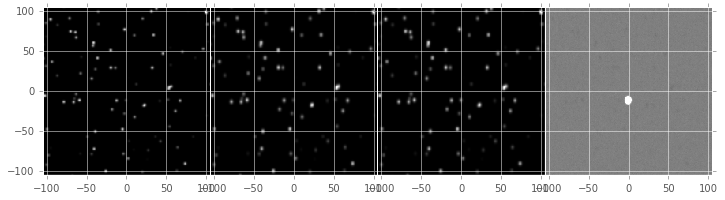

In [17]:
b = (basis2a.T * im2.flatten()).sum(1)
print b.shape

M = np.dot(basis2a.T, basis2a)
print M.shape

pars2, resid, _, _ = np.linalg.lstsq(M, b)
print pars2
#print 'Difference (log10):\n', np.log10(np.abs((pars2-pars)/pars2))

fit2 = (pars2 * basis2a).sum(1).reshape(im1.shape)
print basis2a.shape, fit2.shape

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow((im2 - fit2)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10))
#igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - fit2, axis=None)
#print pars2-pars

(121,) (961, 121)
1.00031218066


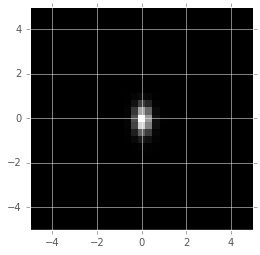

In [18]:
kbasis = np.vstack([b.flatten() for b in basis]).T
print pars2.shape, kbasis.shape
kfit2 = (pars2 * kbasis).sum(1).reshape(basis[0].shape)
print kfit2.sum()
kfit2 /= kfit2.sum()  # this is necessary if the variable source changes a lot - prevent the kernel from incorporating that change in flux
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
plt.imshow(kfit2, extent=extent, interpolation='none', cmap='gray')  # this plots the matching kernel

(511, 511) -0.234890584185 2461.89058086
DescribeResult(nobs=261121, minmax=(9.5593224708168108e-14, 2080824.3567843225), mean=3455.644640407234, variance=1437584625.4156578, skewness=20.60812827838936, kurtosis=542.7146228228985)
DescribeResult(nobs=261121, minmax=(4.9490956537358072e-13, 202802.10013371462), mean=6.6433292948198055, variance=671737.67808865488, skewness=165.78315490790024, kurtosis=31108.235018762196)
DescribeResult(nobs=261121, minmax=(-0.89426981632092251, 450.33554171718959), mean=0.028658755319247373, variance=6.6425334090895882, skewness=115.92510407920047, kurtosis=15217.022162289448)


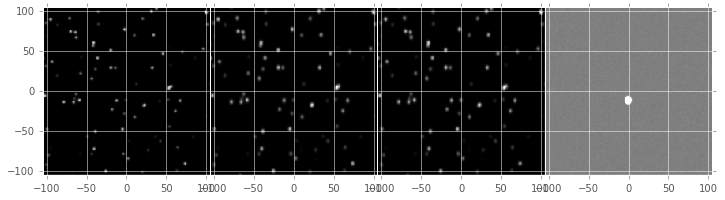

In [19]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit2, mode='constant')
print conv_im1.shape, conv_im1.min(), conv_im1.max()
print scipy.stats.describe((im2 - im1)**2, axis=None)
print scipy.stats.describe((im2 - conv_im1)**2, axis=None)

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # original template (red)
igrid[1].imshow(conv_im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # convolved template (blue)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # science image (dotted, purple)
igrid[3].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10)) # diffim (grey)
print scipy.stats.describe(im2 - conv_im1, axis=None)

Add taking into account PSF variations... (next notebook, #4)

## Compute the "L(ZOGY)" post-conv. kernel from kfit

1.37901446961
-0.0373581718091
1.0


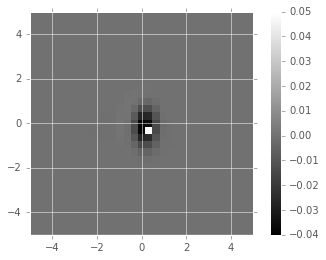

In [20]:
from scipy.fftpack import fft2, ifft2, fftfreq, fftshift

def kernel_ft2(kernel):
    FFT = fft2(kernel)
    return FFT
def post_conv_kernel_ft2(kernel, sig1=1., sig2=1.):
    kft = kernel_ft2(kernel)
    return np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2))
def post_conv_kernel2(kernel, sig1=1., sig2=1.):
    kft = post_conv_kernel_ft2(kernel, sig1, sig2)
    out = ifft2(kft)
    return out

pck = post_conv_kernel2(kfit, sig1=sig2, sig2=sig1)
print pck.real.max()
print pck.real.min()
print pck.real.sum()
pck = np.fft.ifftshift(pck.real)
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
plt.imshow(pck, extent=extent, interpolation='none', cmap='gray', clim=(-0.04,0.05))  # this plots the matching kernel
plt.colorbar()

## Now convolve the image difference with the kernel.

1.0 1.37901446961 -0.0373581718091
DescribeResult(nobs=261121, minmax=(-6.665706677850328, 519.03212041112317), mean=0.028669030859421341, variance=8.0186388874028474, skewness=122.65313494207474, kurtosis=17021.459196098825)
DescribeResult(nobs=261121, minmax=(-0.89426981632092251, 450.33554171718959), mean=0.028658755319247373, variance=6.6425334090895882, skewness=115.92510407920047, kurtosis=15217.022162289448)


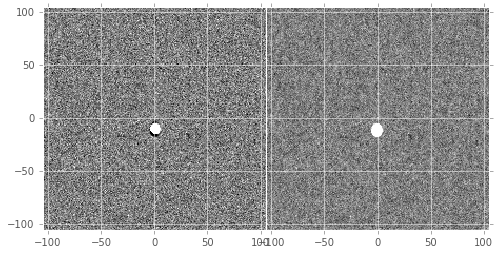

In [21]:
print pck.sum(), pck.max(), pck.min()
#pck /= pck.sum()
pci = scipy.ndimage.filters.convolve(im2-conv_im1, pck, mode='constant')

fig = plt.figure(1, (8, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(pci[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1)) # corrected diffim
igrid[1].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1)) # original diffim
print scipy.stats.describe(pci, axis=None)
print scipy.stats.describe(im2 - conv_im1, axis=None)

-0.996153263472 0.995038679172
Corrected: -0.000562394222349 0.283689930191
Original:  -0.000563312573234 0.208343659622
Expected:  0.282842712475


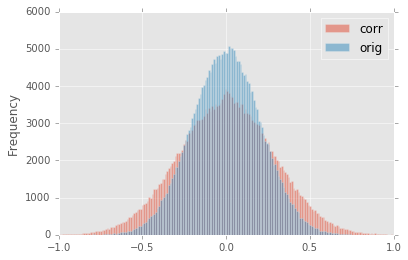

In [22]:
import pandas as pd
#df = pd.DataFrame({'corr': pci.flatten(), 'orig': (im2-conv_im1).flatten()})
#df.plot.hist(alpha=0.5, bins=200)

_, low, upp = scipy.stats.sigmaclip([pci, im2-conv_im1])
print low, upp
tmp1a = pci[(pci>low) & (pci<upp) & (im2-conv_im1>low) & (im2-conv_im1<upp)]
tmp2a = (im2-conv_im1)[(pci>low) & (pci<upp) & (im2-conv_im1>low) & (im2-conv_im1<upp)]
df = pd.DataFrame({'corr': tmp1a.flatten(), 'orig': tmp2a.flatten()})
df.plot.hist(alpha=0.5, bins=200)

print 'Corrected:', np.mean(tmp1a), np.std(tmp1a)
print 'Original: ', np.mean(tmp2a), np.std(tmp2a)
print 'Expected: ', np.sqrt(sig1**2 + sig2**2)

## Compute the (corrected) diffim's new PSF

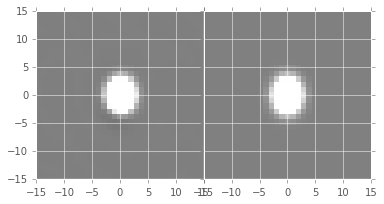

In [23]:
# post_conv_psf = phi_1(k) * sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft(k)**2))
# we'll parameterize phi_1(k) as a gaussian with sigma "psfsig1".

def kernel_ft2(kernel):
    FFT = fft2(kernel)
    return FFT
def post_conv_psf_ft2(psf, kernel, sig1=1., sig2=1.):
    psf_ft = kernel_ft2(psf)
    kft = kernel_ft2(kernel)
    out = psf_ft * np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2))
    return out
def post_conv_psf(psf, kernel, sig1=1., sig2=1.):
    kft = post_conv_psf_ft2(psf, kernel, sig1, sig2)
    out = ifft2(kft)
    return out

# First compute the science image's (im2's) psf -- easy since we parameterized it above when we made the image
im2_psf = gaussian2d(grid, m=[0, 0], s=[psf2, psf2*1.5])

pcf = post_conv_psf(psf=im2_psf, kernel=kfit, sig1=sig2, sig2=sig1)
pcf = pcf.real / pcf.real.sum()

fig = plt.figure(1, (6, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0)
extent = (x0.min(), x0.max(), y0.min(), y0.max())
gim = igrid[0].imshow(pcf, origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-0.01,0.01)) # corrected psf
igrid[1].imshow(im2_psf, origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-0.01,0.01)) # original psf

Look at how detection would compare in the new diffim vs. the original one by convolving them with their psfs.

In [24]:
tmp1 = scipy.ndimage.filters.convolve(pci, pcf, mode='constant')
#plt.plot(xim, tmp1)  # red - corrected
tmp2 = scipy.ndimage.filters.convolve(im2-conv_im1, im2_psf, mode='constant')
#plt.plot(xim, tmp2)  # blue - original

Detect 5-$\sigma$ sources. First compute stats on the convolved diffim's.

-0.20078935153 0.199638384822
10.0977281637 9.08486511238
92 113
0.271125892788 0.227780633312
1: 188 -18 -2 40.6286607748 -1.62195394573 267.769446099
2: 239 -20 -2 31.9359303361 -0.236834646895 225.413362409


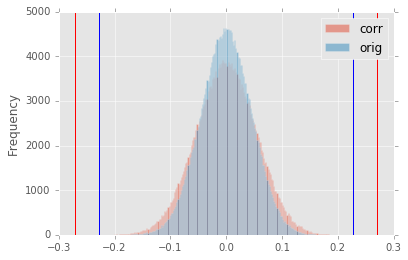

In [25]:
#df = pd.DataFrame({'corr': tmp1.flatten(), 'orig': tmp2.flatten()})
#df.plot.hist(alpha=0.5, bins=200)

_, low, upp = scipy.stats.sigmaclip([tmp1, tmp2])
print low, upp
tmp1a = tmp1[(tmp1>low) & (tmp1<upp) & (tmp2>low) & (tmp2<upp)]
tmp2a = tmp2[(tmp1>low) & (tmp1<upp) & (tmp2>low) & (tmp2<upp)]
df = pd.DataFrame({'corr': tmp1a.flatten(), 'orig': tmp2a.flatten()})
df.plot.hist(alpha=0.5, bins=200)

print tmp1.std()*5., tmp2.std()*5.
print np.sum(np.abs(tmp1) > tmp1.std()*5.), np.sum(np.abs(tmp2) > tmp2.std()*5.)

import scipy.stats
tmp1a, low, upp = scipy.stats.sigmaclip(tmp1)
tmp2a, low, upp = scipy.stats.sigmaclip(tmp2)
print tmp1a.std()*5., tmp2a.std()*5.

det1 = x0im[np.abs(tmp1) > tmp1a.std()*5.]
src1 = tmp1[np.abs(tmp1) > tmp1a.std()*5.]
det2 = x0im[np.abs(tmp2) > tmp2a.std()*5.]
src2 = tmp2[np.abs(tmp2) > tmp2a.std()*5.]
if len(det1) > 0: 
    print '1:', len(det1), det1.min(), det1.max(), src1.mean(), src1.min(), src1.max()
else:
    print '1:', len(det1)
    
if len(det2) > 0:
    print '2:', len(det2), det2.min(), det2.max(), src2.mean(), src2.min(), src2.max()
else:
    print '2:', len(det2)

xaxs = np.linspace(df.min()[0], df.max()[0])
#plt.plot(xaxs, 200*gaussian(xaxs, s=tmp1a.std()), color='r')
#plt.plot(xaxs, 200*gaussian(xaxs, s=tmp2a.std()), color='b')
plt.plot(np.repeat(tmp1a.std()*5., 2), [-0, 5000], color='r')
plt.plot(np.repeat(-tmp1a.std()*5., 2), [-0, 5000], color='r')
plt.plot(np.repeat(tmp2a.std()*5., 2), [-0, 5000], color='b')
plt.plot(np.repeat(-tmp2a.std()*5., 2), [-0, 5000], color='b')